In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
pd.set_option('display.max_columns', None)
from scipy import stats
import os
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV

In [2]:
# datas liste de liste qui contient X, Y prédits et Y observés
def plot_pred_vs_obser(X, y, mdl, title = None, scalerX = None, scalerY = None):
    """
    Plot apply regression interoploation to X and plot graphic
        * Y predicted vs Y observed
    Arguments:
        _X: features dataframe
        _y: target dataframe
        _mdl: model use to regression
        _scalerX: scaler object to apply to X before perform regression
        _saclerY: scaler object to apply to Y invert normalization
    """
    if scalerX is None:
        X_scaled = X
    else:
        X_scaled = scalerX.transform(X)
    if scalerY is None:
        y_pred = mdl.predict(X_scaled)
    else:
        y_pred = scalerY.inverse_transform(mdl.predict(X_scaled))
    #plt.scatter(x, y, color = "blue", alpha = 0.3, label= "observé")
    R2 = r2_score(y, y_pred)
    print("L'erreur moyennen absolue du modèle: {0:.2f} kBtu".format(mean_absolute_error(y_pred, y)))
    print("R² {0:.4f}".format(R2))
    plt.scatter(y, y_pred,  color = "blue", alpha = 0.3)
    plt.xlabel("Y observé")
    plt.ylabel("Y prédit")
    plt.plot(y, y, label = "Valeurs attendues", color = "red")
    plt.text(1, 35, "R² = {0:.4f}".format(R2), verticalalignment='center')
    plt.title(title)
    plt.legend()
    plt.savefig(title+".png")
    plt.show()

In [3]:
def root_mean_squared_log_error(y_pred, y):
    """
    Compute RMSLE, a metric more robust against outliers
    Arguments:
        y_pred: numpy array
        y: numpy array
    """
    return np.sqrt(np.mean(np.log10(y_pred+1) - np.log10(y+1) )**2)

In [4]:
dt = pd.read_csv("clean_data.csv", sep =",", header = 0)
print("{0} lignes et colonnes {1}".format(dt.shape[0], dt.shape[1]))
dt = dt.drop(["Unnamed: 0"], axis=1)
dt = dt.loc[dt["PropertyGFABuilding(s)"]< 200000]
new_dt = dt.copy()

1280 lignes et colonnes 42


## Features

In [5]:
data = new_dt.loc[:,['BuildingType', 'PrimaryPropertyType', 'YearBuilt', 'NumberofBuildings', 
        'NumberofFloors', 'PropertyGFATotal', "PropertyGFAParking", "PropertyGFABuilding(s)"]]
dt_X = pd.get_dummies(data, columns = ["BuildingType", 'PrimaryPropertyType'])

## Target

In [6]:
dt_Y = new_dt.loc[:,["SiteEnergyUse(kBtu)", "TotalGHGEmissions"]]

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dt_X, dt_Y, test_size=0.2, random_state=42)

Energy_test = y_test["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)
CO2_test = y_test["TotalGHGEmissions"].to_numpy().reshape(-1, 1)
Energy_train = y_train["SiteEnergyUse(kBtu)"].to_numpy().reshape(-1, 1)
CO2_train = y_train["TotalGHGEmissions"].to_numpy().reshape(-1, 1)

# Grid search epsilon

In [8]:
def GRID_epsilon(X, Y, epsilons, fold = 5):
    kf = KFold(n_splits=fold, shuffle=True)
    kf.get_n_splits(X)
    list_errors = []
    list_r2 = []
    for train_index, test_index in kf.split(X):
        x_train = X[train_index]
        y_train = Y[train_index]
        x_test = X[test_index]
        y_test = Y[test_index]
        errors = []
        r2 = []
        for epsilon in epsilons:
            model = LinearSVR(max_iter= 50000000, epsilon = epsilon)
            model.fit(x_train, np.ravel(y_train))
            y_pred = model.predict(x_test)
            r2.append(r2_score(y_test, y_pred))
            errors.append(mean_absolute_error(y_test, y_pred))
        list_errors.append(errors)
        list_r2.append(r2)
        #plt.plot(alphas, r2)
        #plt.show()
        #plt.plot(alphas, errors)
        #plt.show()
    return list_errors, list_r2, epsilons

In [9]:
def plot_model(lists, epsilon, y_lab, x_lab, title = "", r2 = True):
    """
    Plot graphic and return best model as function
    a parameter.
    Arguments:
        lists: list of values for each model
        epsilon: parameters used to model evaluation
        y_lab: axis's name
        x_lab: axis's name
    """
    tmp = []
    cpt = 0
    for elmt in lists:
        tmp.append(np.min(elmt))
        plt.plot(epsilon, elmt, label="fold "+str(cpt))
        plt.ylabel(y_lab)
        plt.xlabel(x_lab)
        cpt += 1
    plt.legend()
    plt.title(title)
    plt.show()
    if r2:
        return np.where(tmp == np.max(tmp))[0][0]
    else:
        return np.where(tmp == np.min(tmp))[0][0]

In [10]:
def best_SVR(X, Y, epsilon, C = 1, normalize = False, fold = 5):
    """
    Process kfold SVR and return models with
    their errors and r2 values
    Arguments:
        X: features (numpy array)
        Y: target: (numpy array)
        epislon: margin parameters for SVR
        fold: how many time sample is splited
    """
    scalerX = StandardScaler()
    scalerY = StandardScaler()
    if normalize:
        X_scaled = scalerX.fit_transform(X)
        Y_scaled = scalerY.fit_transform(Y)
    else:
        X_scaled = X
        Y_scaled = Y
    kf = KFold(n_splits=fold, shuffle=True)
    kf.get_n_splits(X)
    list_errors = []
    list_r2 = []
    models_list = []
    for train_index, test_index in kf.split(X):
        x_train = X_scaled[train_index]
        y_train = Y_scaled[train_index]
        x_test = X_scaled[test_index]
        y_test = Y[test_index]
        model = LinearSVR(max_iter= 500000000, epsilon = epsilon, C = C)
        model.fit(x_train, np.ravel(y_train))
        if normalize:
            y_pred = scalerY.inverse_transform(model.predict(x_test))
        else:
            y_pred = model.predict(x_test)
        list_errors.append(mean_absolute_error(y_test, y_pred))
        list_r2.append(r2_score(y_test, y_pred))
        models_list.append(model)
    return list_errors, list_r2, models_list, scalerX, scalerY

# Consommation d'énergie

## Maximisation du R²

In [11]:
#Evaluation de l'erreur suivant les valeurs d'epsilon (paramètre de marge)
list_errors, list_r2, epsilons = GRID_epsilon(X_train.to_numpy(), Energy_train, np.logspace(0,3, 15))

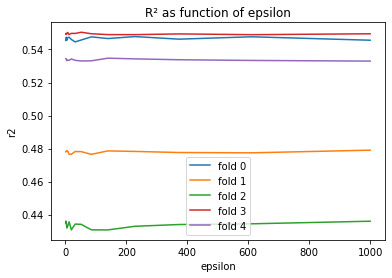

3


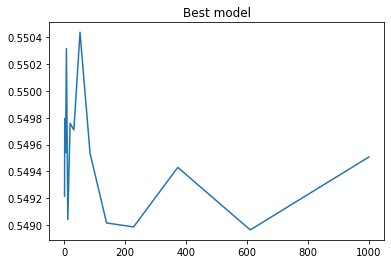

Epsilon qui maximise le R²: [51.79474679]


In [12]:
best_r2 = plot_model(list_r2, epsilons, "r2", "epsilon", "R² as function of epsilon")
print(best_r2)
plt.plot(epsilons, list_r2[best_r2])
plt.title("Best model")
plt.show()
indice = np.where(list_r2[best_r2] == np.max(list_r2[best_r2]))
print("Epsilon qui maximise le R²: {0}".format(epsilons[indice]))
epsilon = epsilons[indice]

### Jeu de test

In [13]:
MAE, list_r2, model, scalerX, scalerY = best_SVR(X_train.to_numpy(), Energy_train, epsilon, normalize = False)

In [14]:
best_model = np.where(list_r2 == np.max(list_r2))[0][0]
print(list_r2)
print("Le meilleur modèle est le {0}".format(best_model))

[0.5240547382529577, 0.44856906686941744, 0.48072297945450404, 0.4853980554465549, 0.55504427278527]
Le meilleur modèle est le 4


In [15]:
y_pred = model[best_model].predict(X_test.to_numpy())
print("MAE "+str(mean_absolute_error(Energy_test, y_pred)) )
r2_score(Energy_test, y_pred)

MAE 1313115.4762509644


0.5359735350621512

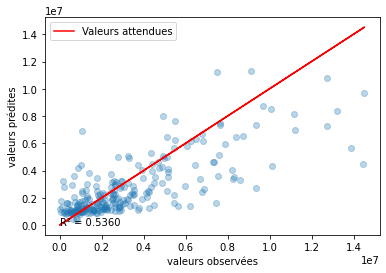

In [16]:
plt.scatter(Energy_test, y_pred, alpha = 0.3)
plt.xlabel("valeurs observées")
plt.ylabel("valeurs prédites")
plt.plot(Energy_test,Energy_test, label= "Valeurs attendues", color = "red")
plt.legend()
plt.text(0.5,0.5, "R² = {0:.4f}".format(r2_score(Energy_test, y_pred)))
plt.show()

## Minimisation du MAE

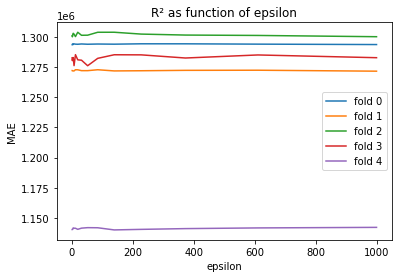

4


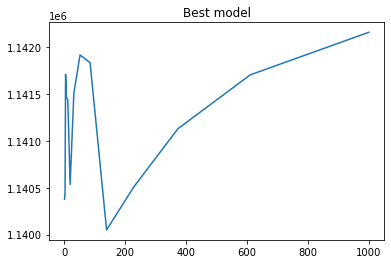

Epsilon qui minimise la MAE: [138.94954944]


In [17]:
best_MAE = plot_model(list_errors, epsilons, "MAE", "epsilon", "R² as function of epsilon", False)
print(best_MAE)
plt.plot(epsilons, list_errors[best_MAE])
plt.title("Best model")
plt.show()
indice = np.where(list_errors[best_MAE] == np.min(list_errors[best_MAE]))
print("Epsilon qui minimise la MAE: {0}".format(epsilons[indice]))

Le modèle qui minimise l'erreur n'est pas celui avec la plus haute valeur de R². On va évaluer les deux modèles sur le jeux de test.

### Jeu de test

In [18]:
MAE, list_r2, model, scalerX, scalerY = best_SVR(X_train.to_numpy(), Energy_train, epsilon, 1, normalize = False)

In [19]:
best_model = np.where(MAE == np.min(MAE))[0][0]
print(MAE)
print("Le meilleur modèle est le {0}".format(best_model))

[1093969.813320322, 1328513.7189794262, 1198129.024757824, 1423635.6689258995, 1281547.996296778]
Le meilleur modèle est le 0


In [20]:
y_pred = model[best_model].predict(X_test.to_numpy())
print("MAE "+str(mean_absolute_error(Energy_test, y_pred)) )
r2_score(Energy_test, y_pred)

MAE 1322901.2028754593


0.5287167231626511

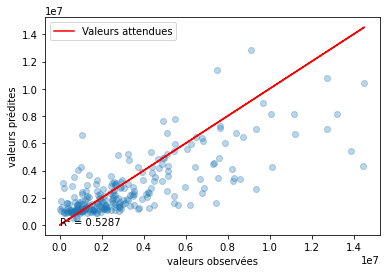

In [21]:
plt.scatter(Energy_test, y_pred, alpha = 0.3)
plt.xlabel("valeurs observées")
plt.ylabel("valeurs prédites")
plt.plot(Energy_test,Energy_test, label= "Valeurs attendues", color = "red")
plt.legend()
plt.text(0.5,0.5, "R² = {0:.4f}".format(r2_score(Energy_test, y_pred)))
plt.show()

# Grid search C et Epsilon

Etude de l'ajout de marges souples sur l'erreur du modèle

In [22]:
param = {'C' : np.logspace(0, 2, 4), 'epsilon' :  np.logspace(0, 2.7, 4)},
grid_search = GridSearchCV(LinearSVR(max_iter = 50000000), cv=5, param_grid = param, 
                      n_jobs = -1, verbose = 2, scoring = "neg_mean_absolute_percentage_error")

grid_search.fit(X_train.to_numpy(), np.ravel(Energy_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=LinearSVR(max_iter=50000000), n_jobs=-1,
             param_grid=({'C': array([  1.        ,   4.64158883,  21.5443469 , 100.        ]),
                          'epsilon': array([  1.        ,   7.94328235,  63.09573445, 501.18723363])},),
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [23]:
grid_search.best_params_

{'C': 1.0, 'epsilon': 63.09573444801933}

In [24]:
C = grid_search.best_params_["C"]
epsilon = grid_search.best_params_["epsilon"]
MAE, list_r2, model, scalerX, scalerY = best_SVR(X_train.to_numpy(), Energy_train, epsilon, C , normalize = False, fold = 5)

In [25]:
best_model = np.where(list_r2 == np.max(list_r2))[0][0]
print(list_r2)
print("Le meilleur modèle est le {0}".format(best_model))

[0.6377851536339477, 0.3862552493566441, 0.45165230128716083, 0.5170748509401989, 0.515481602218146]
Le meilleur modèle est le 0


In [26]:
y_pred = model[best_model].predict(X_test.to_numpy())
print("MAE "+str(mean_absolute_error(Energy_test, y_pred)) )
r2_score(Energy_test, y_pred)

MAE 1332437.614623211


0.5221895085571926

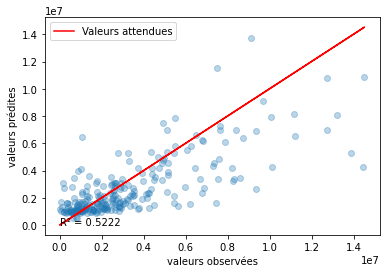

In [27]:
plt.scatter(Energy_test, y_pred, alpha = 0.3)
plt.xlabel("valeurs observées")
plt.ylabel("valeurs prédites")
plt.plot(Energy_test,Energy_test, label= "Valeurs attendues", color = "red")
plt.legend()
plt.text(0.5,0.5, "R² = {0:.4f}".format(r2_score(Energy_test, y_pred)))
plt.show()

# Production de gaz à effet de serre

In [28]:
epsilons = np.logspace(-4,1, 20)
Y = CO2_train
X = X_train
scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(X)
Y_scaled = scalerY.fit_transform(Y)

kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
list_errors = []
list_r2 = []
for train_index, test_index in kf.split(X):
    x_train = X_scaled[train_index]
    y_train = Y_scaled[train_index]
    x_test = X_scaled[test_index]
    y_test = Y[test_index]
    errors = []
    r2 = []
    for epsilon in epsilons:
        model = LinearSVR(max_iter= 50000000, epsilon = epsilon)
        model.fit(x_train, np.ravel(y_train))
        #y_pred = model.predict(x_test)
        y_pred = scalerY.inverse_transform(model.predict(x_test))
        r2.append(r2_score(y_test, y_pred))
        errors.append(mean_absolute_error(y_test, y_pred))
    list_errors.append(errors)
    list_r2.append(r2)


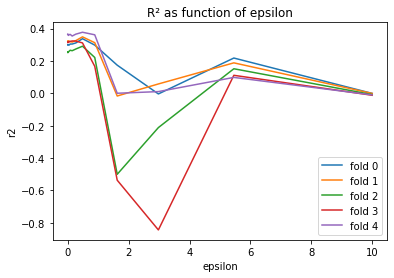

0


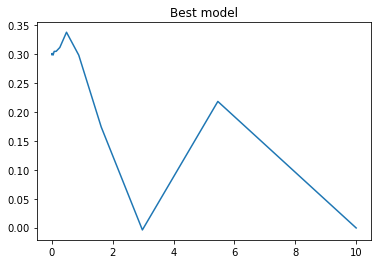

Epsilon qui maximise le R²: [0.48329302]


In [29]:
best_r2 = plot_model(list_r2, epsilons, "r2", "epsilon", "R² as function of epsilon")
print(best_r2)
plt.plot(epsilons, list_r2[best_r2])
plt.title("Best model")
plt.show()
indice = np.where(list_r2[best_r2] == np.max(list_r2[best_r2]))
print("Epsilon qui maximise le R²: {0}".format(epsilons[indice]))
epsilon = epsilons[indice]

### Jeu de test

In [30]:
X = X_train
Y = CO2_train
scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(X)
Y_scaled = scalerY.fit_transform(Y)
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
list_errors = []
list_r2 = []
models_list = []
for train_index, test_index in kf.split(X):
    x_train = X_scaled[train_index]
    y_train = Y_scaled[train_index]
    x_test = X_scaled[test_index]
    y_test = Y[test_index]
    model = LinearSVR(max_iter= 500000000, epsilon = epsilon, C = C)
    model.fit(x_train, np.ravel(y_train))
    y_pred = scalerY.inverse_transform(model.predict(x_test))
    list_errors.append(mean_absolute_error(y_test, y_pred))
    list_r2.append(r2_score(y_test, y_pred))
    models_list.append(model)

MAE = list_errors
model = models_list
list_r2 = list_r2

In [31]:
best_model = np.where(list_r2 == np.max(list_r2))[0][0]
print(list_r2)
print("Le meilleur modèle est le {0}".format(best_model))

[0.4121789132989345, 0.2681065518280754, 0.2960833810918675, 0.3062907118005438, 0.3877436231564342]
Le meilleur modèle est le 0


In [32]:
y_pred = scalerY.inverse_transform(model[best_model].predict(scalerX.fit_transform(X_test)))
print("MAE "+str(mean_absolute_error(CO2_test, y_pred)) )
r2_score(CO2_test, y_pred)

MAE 34.30708375790149


0.3691547409216204

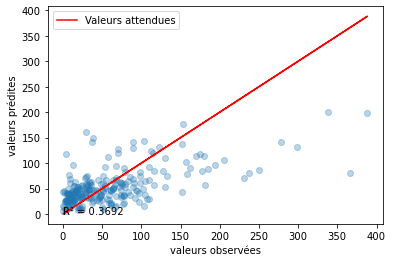

In [33]:
plt.scatter(CO2_test, y_pred, alpha = 0.3)
plt.xlabel("valeurs observées")
plt.ylabel("valeurs prédites")
plt.plot(CO2_test,CO2_test, label= "Valeurs attendues", color = "red")
plt.legend()
plt.text(0.5,0.5, "R² = {0:.4f}".format(r2_score(CO2_test, y_pred)))
plt.show()

Le modèle qui minimise l'erreur n'est pas celui avec la plus haute valeur de R². On va évaluer les deux modèles sur le jeux de test.

# Grid search C et Epsilon

Etude de l'ajout de marges souples sur l'erreur du modèle

In [54]:
param = {'C' : np.logspace(-1, 2, 7), 'epsilon' :  np.logspace(-3, 3, 6), 
         'kernel': ('linear', 'rbf','poly'),  "degree" : [1, 2, 3, 4, 5, 6]}

grid_search = GridSearchCV(SVR(max_iter = 50000000), cv=5, param_grid = param, 
                      n_jobs = -1, verbose = 2, scoring = "r2")

X = X_train
Y = CO2_train
scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(X)
Y_scaled = scalerY.fit_transform(Y)
grid_search.fit(X_scaled, np.ravel(Y_scaled))

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


GridSearchCV(cv=5, estimator=SVR(max_iter=50000000), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.31622777,   1.        ,   3.16227766,
        10.        ,  31.6227766 , 100.        ]),
                         'degree': [1, 2, 3, 4, 5, 6],
                         'epsilon': array([1.00000000e-03, 1.58489319e-02, 2.51188643e-01, 3.98107171e+00,
       6.30957344e+01, 1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly')},
             scoring='r2', verbose=2)

In [49]:
grid_search.best_params_

{'C': 3.1622776601683795, 'degree': 1, 'epsilon': 0.1, 'kernel': 'rbf'}

### Jeu de test

In [50]:
X = X_train
Y = CO2_train
scalerX = StandardScaler()
scalerY = StandardScaler()
X_scaled = scalerX.fit_transform(X)
Y_scaled = scalerY.fit_transform(Y)
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
list_errors = []
list_r2 = []
models_list = []
for train_index, test_index in kf.split(X):
    x_train = X_scaled[train_index]
    y_train = Y_scaled[train_index]
    x_test = X_scaled[test_index]
    y_test = Y[test_index]
    model = SVR(max_iter= 50000000, epsilon = grid_search.best_params_['epsilon'],
        C = grid_search.best_params_['C'], degree = grid_search.best_params_['degree'],
        kernel = grid_search.best_params_['kernel'])
    model.fit(x_train, np.ravel(y_train))
    y_pred = scalerY.inverse_transform(model.predict(x_test))
    list_errors.append(mean_absolute_error(y_test, y_pred))
    list_r2.append(r2_score(y_test, y_pred))
    models_list.append(model)

MAE = list_errors
model = models_list
list_r2 = list_r2

In [51]:
best_model = np.where(list_r2 == np.max(list_r2))[0][0]
print(list_r2)
print("Le meilleur modèle est le {0}".format(best_model))

[0.38350803589303795, 0.410330137717425, 0.3421153309594873, 0.1387747185973165, 0.42350305151389744]
Le meilleur modèle est le 4


In [52]:
y_pred = scalerY.inverse_transform(model[best_model].predict(scalerX.fit_transform(X_test)))
print("MAE "+str(mean_absolute_error(CO2_test, y_pred)) )
r2_score(CO2_test, y_pred)

MAE 32.73631344169786


0.3428187437888547

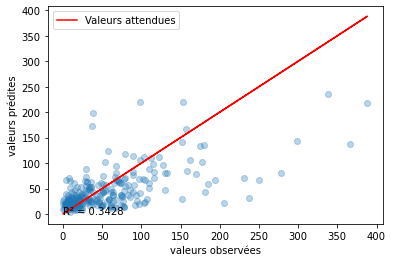

In [53]:
plt.scatter(CO2_test, y_pred, alpha = 0.3)
plt.xlabel("valeurs observées")
plt.ylabel("valeurs prédites")
plt.plot(CO2_test,CO2_test, label= "Valeurs attendues", color = "red")
plt.legend()
plt.text(0.5,0.5, "R² = {0:.4f}".format(r2_score(CO2_test, y_pred)))
plt.show()